![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# XAI in Deep Learning-Based Signal Analysis: The Class Activation Map (CAM)

In this Notebook, we will delve into the utilization of CAM to reveal the sections of a signal that a ResNet-50 model trained on signal data considers crucial during its prediction process.

### Imports

Let's start with importing all required Python packages.

In [3]:
%matplotlib inline
import sys 
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn


sys.path.append('../xai-model-specific/cnn_classification')
from model import ResNet, ResNetBlock
from dataset import ECG

We fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [4]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

Let's set some paths for the weights of the model and the location of the data

In [12]:
model_weights_path = '../xai-model-specific/cnn_classification/weights/model_weights9.pth'
test_data_path = '../xai-model-specific/archive-4/mitbih_test.csv'

We have trained a ResNet-50 model for 10 epochs on the Electrocardiogram (ECG) Heartbeat Categorization Dataset. The ResNet-50 uses conv1d layers instead of conv2d layers. 

The dataset is made up of two groups of heartbeat signals, originating from two well-known heartbeat classification datasets - the MIT-BIH Arrhythmia Dataset and The PTB Diagnostic ECG Database. We used the MIT-BIH Arrhythmia Dataset to train our model. This dataset consists of 87554 samples for train, 21892 samples for test, and 5 categories (['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4])

The dataset is organized in CSV files. Inside every CSV file, there's a matrix structure. Each row in the matrix signifies an individual ECG signal instance. The last column in each row determines the specific category the example belongs to.

Let's load the model.

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(ResNetBlock, [2, 2, 2, 2], num_classes=5)
model = model.to(device)
model.load_state_dict(torch.load(model_weights_path, map_location=torch.device(device=device)))

<All keys matched successfully>

We have created an ECG class that load the dataset.

In [14]:
ecg = ECG(test_data_path)

## How to Get CAM

- Every unit in this GAP layer is multiplied by its associated feature map. 
- The weighted feature maps are combined to produce a Class Activation Map (CAM). 
- We then nornalize the produced CAM.

CAM = Σ_k (w_k * A_k)

In [ ]:
def return_cam(model, x, label):
    feature_map = x.detach().clone()
    cam_weights = model.fc.weight[label]
    cams = (cam_weights.view(*feature_map.shape[:2], 1) *
    feature_map).mean(1, keepdim=False)
    return logits, cams

In [5]:
def normalize_scoremap(cam):
    if np.isnan(cam).any():
        return np.zeros_like(cam)
    if cam.min() == cam.max():
        return np.zeros_like(cam)

    cam -= cam.min()
    cam /= cam.max()
#     cam -= cam.mean()
#     cam /= cam.std()
    return cam

#%% # Get the numpy array of a tensor
def t2n(t):
    return t.detach().cpu().numpy().astype(float)

def n2t(n):
    return torch.from_numpy(n).float()

#%% # Generate the CAM
def compute_cams(model, X_test, y_test, device, height=1, width=10000):
    # model = return_model("ResNet")
    h, w = height, width
    
    # Get the logits as well as the CAM for a specific sample
    x, cams = model(torch.unsqueeze(X_test,0).to(device), torch.from_numpy(np.asarray(y_test)).to(device), True)
    
    x = nn.Softmax(dim=-1)(x)

    cams = t2n(cams)

    # Resize the CAM to the same size of the original signal and normalize the values
    cam_resized = cv2.resize(cams, (h, w), interpolation=cv2.INTER_CUBIC)
    cam_normalized = normalize_scoremap(cam_resized)  

    # Return the normalized CAM and a bool if the predicted label is correct or not 
    return cam_normalized, torch.argmax(x) == y_test 

In [24]:
def plot_maps(value):
    fig, axs = plt.subplots(figsize=(15,5))
    # data_name = key
    cam = value[0]
    # print("value", signal.shape)
    signal = value[-1][-1]
    pcm = axs.imshow(cam, cmap='Reds',  aspect="auto", \
        extent=[0, len(signal), math.floor(signal.min()), math.ceil(signal.max())], alpha=1.0)
    # axs.set_title(data_name)
    axs.plot(signal, 'k')
    fig.colorbar(pcm, ax=axs, shrink=0.6)#
    # plt.savefig(os.path.join(folder,'cam'+str(i)+'.png'))
    # plt.close(fig) 
    plt.show()

cam (1, 187)


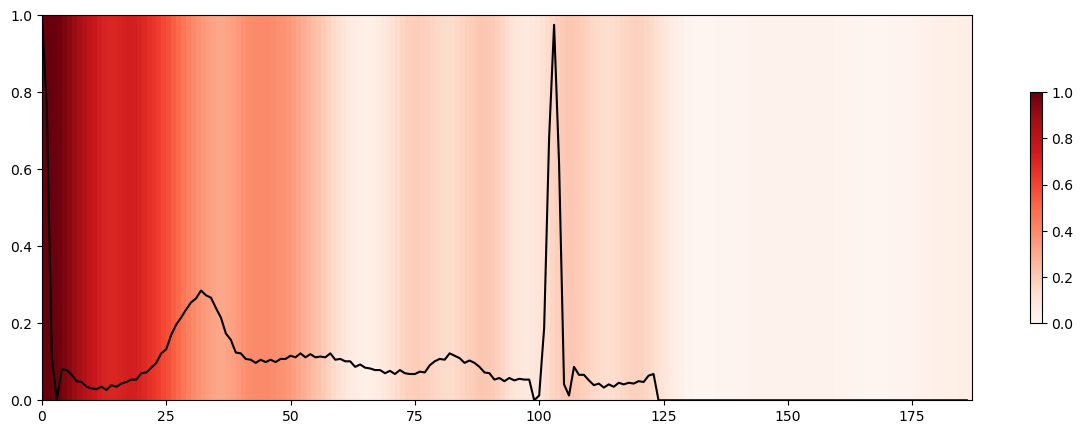

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(ResNetBlock, [2, 2, 2, 2], num_classes=5)
model = model.to(device)
i = 0
model.load_state_dict(torch.load("../xai-model-specific/cnn_classification/weights/model_weights9.pth", map_location=torch.device(device=device)))
#%%
ecg = ECG("/p/project/training2324/benassou1/XAI-Tutorials/xai-model-specific/archive-4/mitbih_test.csv")

ecg0 = ecg[i]
ecg_h = ecg0[0].shape[-1]
ecg_w = ecg0[0].shape[0]
#%%
# trainloader = DataLoader(ecg, batch_size=4, shuffle=False, num_workers=90)

cam, output = compute_cams(model, ecg0[0], ecg0[-1], device=device, height=ecg_h, width=ecg_w)
print("cam", cam.shape)
plot_maps([cam, ecg0[0]], "test", i)